``Start modelling on metadata again. No imgs only metadata.``

```ONLY one thing: IMPROVE```


# Load data and dependencies

In [1]:
import warnings
import sys
import os
import time
import joblib
import random
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from joblib import Parallel, delayed

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, minmax_scale
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

warnings.filterwarnings('ignore')

In [2]:
metadata = pd.read_csv('../data/metadata.csv')
sub_format = pd.read_csv('../data/submission_format.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

# Utils

In [3]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [4]:
def dens_to_sev(x: float)-> int:
    """takes in density value in cells/ml and returns severity category"""
    if (x < 20_000) : return 1
    elif (x >= 20_000) and (x < 100_000) : return 2
    elif (x >= 100_000) and (x < 1_000_000) : return 3
    elif (x >= 1_000_000) and (x < 10_000_000) : return 4
    elif x > 10_000_000 : return 5

In [5]:
def region_wise_peformance(y_data=None, preds=None):
    """
    returns classifcation report for each region
    y_data : pd.DataFrame
    preds : np.array
    
    """
    y_data = y_data.copy(deep=True)
    y_data['preds'] = preds
    for region in sorted(y_data.region.unique()):
        print(region)
        print(classification_report(y_data[y_data.region == region].severity, y_data[y_data.region == region].preds))
        print()
    

In [6]:
#  Utils
def get_data_by_date( date=None, data=None):
    return data[data.date == date]


def get_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

def analyize_matches(y_true, y_pred, plot=False):
    print("Exact matches: ", sum(y_true == y_pred) / len(y_true))
    print("Missed by 1: ", sum(abs(y_true - y_pred) == 1) / len(y_true))
    print("Missed by 2: ", sum(abs(y_true - y_pred) == 2) / len(y_true))
    print("Missed by 3: ", sum(abs(y_true - y_pred) == 3) / len(y_true))
    print("Missed by 4: ", sum(abs(y_true - y_pred) == 4) / len(y_true))
    
    stupid_vals = []
    for i in range(1, 6):
        stupid_vals.append(
            ((sum([1 for x, y in zip(y_true, y_pred) if x == i and y == i])/len(y_true))*100, (sum(y_true == i)/len(y_true))*100)
            )

    print()
    for i in range(5):
        print(f"Severity {i+1} : accuracy: {np.round(stupid_vals[i][0], 3)} % - prevalence: {np.round(stupid_vals[i][1], 3)} %")
    
    try:
        print()
        print("Classification report:")
        print(classification_report(y_true, y_pred))
    except Exception as e:
        print(e)
        print("Classification report failed")
        
    if plot:
        print()
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Reds')

# Add date fts

In [18]:
metadata.date = pd.to_datetime(metadata.date)
metadata['year'] = metadata.date.dt.year
metadata['month'] = metadata.date.dt.month
metadata['week'] = metadata.date.dt.isocalendar().week

seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1
}

reg_sev_map = {
    'midwest': 2,
    'northeast': 2,
    'south' : 2,
    'west' : 4
}

reg_map = {
    'south' : 0,
    'northeast' : 1,
    'west' : 2,
    'midwest' : 3
}

metadata['season'] = metadata.month.map(seasons)

region = pd.concat((train_labels, sub_format[['region', 'uid']]), axis=0)

all_data = pd.merge(metadata, region, on='uid', how='left')
data = all_data.copy(deep=True)
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,1.0,9682.0


# CV

In [32]:
def train_eval(model, X_train=None, X_val=None, y_train=None, y_val=None, X_test=None, y_test=None, task='reg'):
    """
    train and eval util func,
    returns trained model, soft_preds, and tr, val, test rmses
    REMEMBER returns soft-preds
    """
    
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    if task == 'reg':
        val_rmse = rmse(y_val, np.clip(np.round(val_preds), 1, 5))
        train_rmse = rmse(y_train, np.clip(np.round(model.predict(X_train)), 1, 5))   # don't forget to clip!
    else:
        val_rmse = rmse(y_val, val_preds)
        train_rmse = rmse(y_train, model.predict(X_train))
        
    print("Train RMSE: ", train_rmse)
    print("Val RMSE:", val_rmse)
    if X_test is not None and y_test is not None:
        test_rmse = mse(y_test, np.clip(np.round(model.predict(X_test)), 1, 5), squared=False)
        print('TEST RMSE: ', test_rmse)
    else:
        test_rmse = 0
        
    # print("TEST RMSE:", mse(y_val, np.round(model.predict(X_val)), squared=False))
    return model, val_preds, train_rmse, val_rmse, test_rmse

In [33]:

def cv_it(model, X_train=None, y_train=None, X_test=None, y_test=None, splits=10, cv_predict=False, task='reg'):
    """ 
    cv in stratified kfold fashion, 
    returns train, val, test rmses, and cv preds for test and train if cv_predict=True
    remember to round preds
    And also send in "dates" to make val set similar to test set
    """
    
    skf = StratifiedKFold(n_splits=splits, random_state=12_000, shuffle=True)
    # tscv = TimeSeriesSplit(n_splits=splits, test_size=200)
    print('Using cols: ', X_train.columns.values)

    train_rmses = []
    val_rmses = []
    test_rmses = []
    cvpreds_test, cvpreds_train = None, None

    if cv_predict:
        if X_test is not None: test_shape = X_test.shape[0]
        else: test_shape = 6510
        cvpreds_test = np.zeros(shape=(test_shape, splits))
        cvpreds_train = np.zeros(shape=(len(X_train)))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):

        print(f'----------------------------------Fold-{fold}------------------------------------')
        X_train_subset, y_train_subset = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_subset, y_val_subset = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        try:
            # make val set more similar to test set by making val_set.latlng.isin(trian_set.latlng) --> 0
            X_val_subset['latlng'] = X_val_subset.latitude.astype(str) + '_' + X_val_subset.longitude.astype(str)
            X_train_subset['latlng'] = X_train_subset.latitude.astype(str) + '_' + X_train_subset.longitude.astype(str)

            drp_idx = X_val_subset[X_val_subset.latlng.isin(X_train_subset.latlng)].index
            
            # X_train_subset = pd.concat([X_train_subset, X_val_subset.loc[drp_idx]], axis=0) # causes cv leak
            # y_train_subset = pd.concat([y_train_subset, y_val_subset.loc[drp_idx]], axis=0)

            X_val_subset.drop(drp_idx, inplace=True)
            y_val_subset.drop(drp_idx, inplace=True)
            
            # make sure no latlng is in both train and val_data
            assert X_val_subset.latlng.isin(X_train_subset.latlng).sum() == 0
            
            # drop latlng
            X_val_subset.drop('latlng', axis=1, inplace=True)
            X_train_subset.drop('latlng', axis=1, inplace=True)

        except Exception as e:
            print('Error in making val set more similar to test set')
            print(e)
        
        assert X_train_subset.columns.tolist() == X_val_subset.columns.tolist()
        # assert X_train_subset.columns.tolist() == X_test.columns.tolist()

        print(f'Training on {X_train_subset.shape[0]} samples' )
        print(f'Validating on {X_val_subset.shape[0]} samples' )

        print(y_val_subset.value_counts(normalize=True))
        model, val_preds, train_rmse, val_rmse, test_rmse= train_eval(
                                    model=model, 
                                    X_train=X_train_subset, 
                                    y_train=y_train_subset, 
                                    X_val=X_val_subset, 
                                    y_val=y_val_subset,
                                    X_test=X_test,
                                    y_test=y_test,
                                    task=task
                                    )

        sns.barplot(model.feature_importances_, model.feature_names_in_)

        val_rmses.append(val_rmse)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        
        if cv_predict:
            # save predictions for ensembling
            if X_test is not None:
                cvpreds_test[:, fold] = model.predict(X_test)
            cvpreds_train[val_idx] = model.predict(X_train.iloc[val_idx])
                    
    print()
    print("Mean Train RMSE:", np.mean(train_rmses), "std:", np.std(train_rmses))
    print("Mean Val RMSE:", np.mean(val_rmses), "std:", np.std(val_rmses))
    print("Mean Test RMSE:", np.mean(test_rmses), "std:", np.std(test_rmses))
    
    return cvpreds_test, cvpreds_train, np.mean(train_rmses), np.mean(val_rmses), np.mean(test_rmses)

# KNN

In [10]:
def knn(row=None, train_data=None, k=1):
    """
    row : pd.Series (row from val_data)
    train_data : pd.DataFrame (all_data)
    k : int number of nearest neighbours to consider
    
    algo:
    1. Get past month data collected till the current row
    2. Get the k nearest neighbours (geodesic dist using lat, lng) from the above data
    3. Get the mean of the severity from the above rows
    4. Return the mean of the nearest neighbours severity

    """
    
    if row is None:
        print('Row None bruv!')
        return None
    
    uid = row.uid
    date = row.date
    region = row.region
    past_date = date - pd.Timedelta(days=30)
    
    past_month_data = train_data[(train_data.date < date) & (train_data.date >= past_date)]
    past_month_data.sort_values(by='date', inplace=True)
    
    # if no past data, return the mean of the region
    if len(past_month_data) == 0:
        return reg_sev_map[region]
        
    dist_matrix =pd.DataFrame(columns=['uid', 'dist'])       # 0th col for uid, 1st col for dist
    for i, past_row in enumerate(past_month_data.itertuples()):
        dist_matrix.loc[i, 'uid'] = past_row.uid
        dist_matrix.loc[i, 'dist'] = get_distance(row.latitude, row.longitude, past_row.latitude, past_row.longitude)   # returns geodesic dist in km

    # get mean of top k nearest neighbours
    n_uids = dist_matrix.sort_values(by='dist').head(k).uid.values
    nn_severity = train_data[train_data.uid.isin(n_uids)].severity.mean()
    
    return np.round(nn_severity)


In [11]:
def knn_wrapper(k=15, train_data=None, val_data=None):
    sev_list = Parallel(n_jobs=-1, backend='loky')([delayed(knn)(row, train_data=train_data, k=k) for row in val_data.itertuples()])
    return sev_list

# Adding features

## Expanding fts.

In [12]:
data = all_data.sort_values(by='date')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


In [13]:
train_data_ = data[data.split == 'train']
train_data_.severity.value_counts(normalize=True)

1.0    0.439449
4.0    0.207913
2.0    0.189859
3.0    0.159379
5.0    0.003400
Name: severity, dtype: float64

In [14]:
grp_by_rm = data.groupby(['region', 'month']).severity.expanding(1).mean()
grp_by_rm = grp_by_rm.map(np.round)
print(grp_by_rm.isna().sum())  
grp_by_rm.fillna(grp_by_rm.groupby('region').transform('mean'), inplace=True)
print(grp_by_rm.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), grp_by_rm.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(grp_by_rm.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))

# remember rmse is not representative of test set!!
# this is slightly better than the all 1s

72
0
Exact matches:  0.5014067995310668
Missed by 1:  0.44021101992966
Missed by 2:  0.04824150058616647
Missed by 3:  0.009730363423212192
Missed by 4:  0.00041031652989449003

Severity 1 : accuracy: 19.965 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.767 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.545 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.864 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.72      0.45      0.56      7497
         2.0       0.26      0.67      0.37      3239
         3.0       0.18      0.03      0.06      2719
         4.0       0.86      0.81      0.84      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.50     17060
   macro avg       0.40      0.39      0.36     17060
weighted avg       0.57      0.50      0.50     17060



0.8528278592784991

In [15]:
data['exp_grp_by_rm'] = grp_by_rm.droplevel(0).droplevel(0).loc[data.index]
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,exp_grp_by_rm
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0,1.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0,1.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0,1.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0,1.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0


In [17]:
grp_by_rs = data.groupby(['region', 'season']).severity.expanding(1).mean()
grp_by_rs = grp_by_rs.map(np.round)
print(grp_by_rs.isna().sum())  
grp_by_rs.fillna(grp_by_rs.groupby('region').transform('mean'), inplace=True)
print(grp_by_rs.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), grp_by_rs.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(grp_by_rs.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))


5
0
Exact matches:  0.5026377491207503
Missed by 1:  0.4370457209847597
Missed by 2:  0.04882766705744431
Missed by 3:  0.011078546307151231
Missed by 4:  0.00041031652989449003

Severity 1 : accuracy: 19.66 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.749 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.047 % - prevalence: 15.938 %
Severity 4 : accuracy: 17.808 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.71      0.45      0.55      7497
         2.0       0.25      0.67      0.37      3239
         3.0       0.04      0.00      0.01      2719
         4.0       0.85      0.86      0.85      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.50     17060
   macro avg       0.37      0.40      0.36     17060
weighted avg       0.54      0.50      0.49     17060



0.8594349134502333

In [ ]:
data['exp_grp_by_rs'] = grp_by_rs.droplevel(0).droplevel(0).loc[data.index]
data

In [ ]:
grp_by_rw = data.groupby(['region', 'week']).severity.expanding(1).mean()
grp_by_rw = grp_by_rw.map(np.round)
print(grp_by_rw.isna().sum())  
grp_by_rw.fillna(grp_by_rw.groupby('region').transform('mean'), inplace=True)
print(grp_by_rw.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), grp_by_rw.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(grp_by_rw.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))


In [ ]:
data['exp_grp_by_rw'] = grp_by_rw.droplevel(0).droplevel(0).loc[data.index]
data

In [ ]:
data[data.columns[data.columns.str.startswith('exp')]].corr()
# wonder if these are useful!

## Rolling fts.

In [ ]:
# best rolling window is 7 days

In [ ]:
data = all_data.sort_values(by='date')
train_data = data[data.split == 'train']
test_data =  data[data.split == 'test']

data

In [ ]:
x = data.groupby('region').severity.rolling(7, min_periods=1).mean().map(np.round).fillna(data.groupby('region').severity.transform('mean')).isna()
x.droplevel(0).loc[data.index]

In [ ]:
data[x.droplevel(0).loc[data.index]].index

In [ ]:
data[x.droplevel(0).loc[data.index]].index.isin(test_data.index).sum()

# Split

In [19]:
test_data = data[data.split == 'test']
test_data.shape, data.shape

((6510, 12), (23570, 12))

In [20]:
train_data = data[data.split == 'train']
train_data.shape, data.shape

((17060, 12), (23570, 12))

In [21]:
tr_data, val_data = train_test_split(train_data, test_size=0.15, random_state=123456789, shuffle=True)
tr_data.shape, val_data.shape

((14501, 12), (2559, 12))

In [22]:
X_test = test_data[train_data.columns]
X_test

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
12,aair,33.042600,-117.076000,2014-11-01,test,2014,11,44,4,west,NaN,NaN
14,aajw,40.703968,-80.293050,2015-08-26,test,2015,8,35,3,northeast,NaN,NaN
15,aalr,38.972500,-94.672930,2019-08-26,test,2019,8,35,3,midwest,NaN,NaN
16,aalw,34.279000,-118.905000,2018-01-08,test,2018,1,2,1,west,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test,2019,7,28,3,northeast,NaN,NaN
23560,zzrv,36.875400,-121.561000,2019-09-17,test,2019,9,38,4,west,NaN,NaN
23563,zzsx,34.210000,-78.929389,2019-07-16,test,2019,7,29,3,south,NaN,NaN
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN


# Train 

In [23]:
train_data.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'year', 'month',
       'week', 'season', 'region', 'severity', 'density'],
      dtype='object')

In [24]:
drop_cols = ['date', 'uid', 'severity', 'year', 'split', 'density',]
drop_cols

['date', 'uid', 'severity', 'year', 'split', 'density']

In [25]:
X_train = tr_data.drop(columns=drop_cols)
X_train.week = X_train.week.astype('int')
X_train.region = X_train.region.map(reg_map)  # reg map is better than reg_sev_map
y_train = tr_data.severity

X_val = val_data.drop(columns=drop_cols)
X_val.week = X_val.week.astype('int')
X_val.region = X_val.region.map(reg_map)
y_val = val_data.severity

In [26]:
assert X_train.columns.to_list() == X_val.columns.to_list()
assert y_train.index.to_list() == X_train.index.to_list()
assert y_val.index.to_list() == X_val.index.to_list()

In [27]:
y_train = y_train - 1
y_val = y_val - 1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=12000,
              reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'month' 'week' 'season' 'region']
----------------------------------Fold-0------------------------------------
Training on 13050 samples
Validating on 848 samples
0.0    0.600236
1.0    0.231132
2.0    0.143868
3.0    0.024764
Na

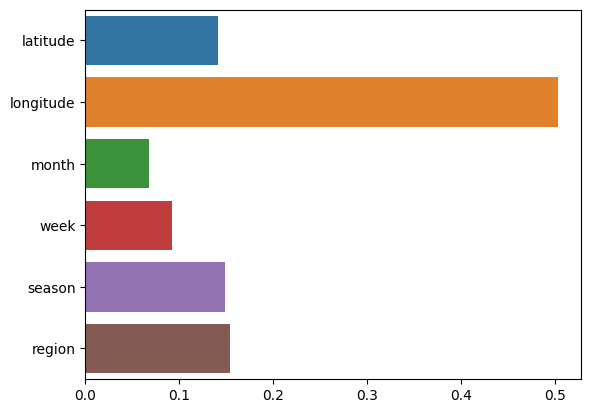

In [35]:
xgb = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

te_preds, tr_preds ,*_ = cv_it(model=xgb, X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val, splits=10, cv_predict=True, task='clf')

In [ ]:
# 0.9392738333619247 wrong!!

In [36]:
te_preds, tr_preds

(array([[1., 1., 0., ..., 1., 0., 1.],
        [1., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([3., 3., 0., ..., 0., 2., 0.]))

In [37]:
pd.Series(np.round(np.mean(te_preds, axis=1) + 1)).value_counts(normalize=True)

1.0    0.506839
4.0    0.207503
2.0    0.173896
3.0    0.110199
5.0    0.001563
dtype: float64

In [40]:
analyize_matches(y_val + 1, np.round(np.mean(te_preds, axis=1) + 1))

analyize_matches(y_train + 1, tr_preds + 1)

Exact matches:  0.6639312231340367
Missed by 1:  0.26572880031262214
Missed by 2:  0.06486908948808129
Missed by 3:  0.0042985541227041815
Missed by 4:  0.0011723329425556857

Severity 1 : accuracy: 36.42 % - prevalence: 43.923 %
Severity 2 : accuracy: 6.096 % - prevalence: 19.226 %
Severity 3 : accuracy: 5.197 % - prevalence: 15.826 %
Severity 4 : accuracy: 18.679 % - prevalence: 20.594 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.43 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.72      0.83      0.77      1124
         2.0       0.35      0.32      0.33       492
         3.0       0.47      0.33      0.39       405
         4.0       0.90      0.91      0.90       527
         5.0       0.00      0.00      0.00        11

    accuracy                           0.66      2559
   macro avg       0.49      0.48      0.48      2559
weighted avg       0.64      0.66      0.65      2559

Exact matches:  0.6674022481208193
Missed by

In [41]:
region_wise_peformance(y_data=tr_data, preds=tr_preds + 1)
print('-------------------------------')
region_wise_peformance(y_data=val_data, preds=np.round(np.mean(te_preds, axis=1) + 1))

midwest
              precision    recall  f1-score   support

         1.0       0.79      0.76      0.77       665
         2.0       0.38      0.27      0.32       362
         3.0       0.54      0.71      0.62       658
         4.0       0.48      0.27      0.35       164
         5.0       0.00      0.00      0.00        11

    accuracy                           0.60      1860
   macro avg       0.44      0.40      0.41      1860
weighted avg       0.59      0.60      0.59      1860


northeast
              precision    recall  f1-score   support

         1.0       0.75      0.80      0.78       472
         2.0       0.58      0.57      0.58       278
         3.0       0.49      0.49      0.49       182
         4.0       0.30      0.15      0.20        41
         5.0       0.25      0.09      0.13        11

    accuracy                           0.64       984
   macro avg       0.47      0.42      0.43       984
weighted avg       0.63      0.64      0.64       984


so

# Test Predictions

In [42]:
X_train.columns.to_list() == X_val.columns.to_list()

True

In [43]:
X_test = X_test[X_train.columns]
assert X_test.columns.tolist() == X_train.columns.tolist()

X_test

,latitude,longitude,month,week,season,region
1,36.559700,-121.510000,8,35,3,west
12,33.042600,-117.076000,11,44,4,west
14,40.703968,-80.293050,8,35,3,northeast
15,38.972500,-94.672930,8,35,3,midwest
16,34.279000,-118.905000,1,2,1,west
...,...,...,...,...,...,...
23556,40.136410,-80.473740,7,28,3,northeast
23560,36.875400,-121.561000,9,38,4,west
23563,34.210000,-78.929389,7,29,3,south
23565,36.708500,-121.749000,12,49,1,west


In [44]:
all_X_train = pd.concat([X_train, X_val], axis=0)
all_y_train = pd.concat([y_train, y_val], axis=0)

assert all_X_train.shape[0] == all_y_train.shape[0]
assert all_X_train.columns.tolist() == X_test.columns.tolist()

all_X_train.shape, all_y_train.shape

((17060, 6), (17060,))

In [45]:
X_test.week = X_test.week.astype('int')
X_test.region = X_test.region.map(reg_map)

Using cols:  ['latitude' 'longitude' 'month' 'week' 'season' 'region']
----------------------------------Fold-0------------------------------------
Training on 15354 samples
Validating on 988 samples
0.0    0.596154
1.0    0.239879
2.0    0.127530
3.0    0.033401
4.0    0.003036
Name: severity, dtype: float64
Train RMSE:  0.6599406701813711
Val RMSE: 0.889661719817427
----------------------------------Fold-1------------------------------------
Training on 15354 samples
Validating on 985 samples
0.0    0.604061
1.0    0.241624
2.0    0.131980
3.0    0.019289
4.0    0.003046
Name: severity, dtype: float64
Train RMSE:  0.6581618511235104
Val RMSE: 0.8766572413330799
----------------------------------Fold-2------------------------------------
Training on 15354 samples
Validating on 1009 samples
0.0    0.589693
1.0    0.249752
2.0    0.139742
3.0    0.019822
4.0    0.000991
Name: severity, dtype: float64
Train RMSE:  0.6569732960206615
Val RMSE: 0.8887581117320251
--------------------------

(6510, 10)

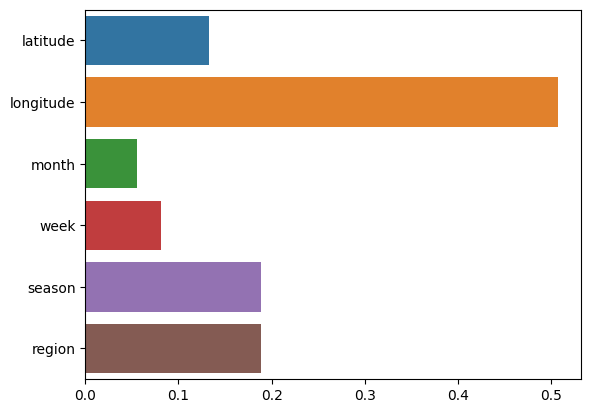

In [55]:
xgb_reg = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
test_preds_cv, train_preds_cv,  *_ = cv_it(xgb_reg, all_X_train, all_y_train, X_test=X_test, splits=10, cv_predict=True, task='clf')
test_preds_cv.shape

In [56]:
preds_rmr = np.round(np.mean(np.round(test_preds_cv), axis=1)) # mean of rounded predictions
preds_rm = np.round(np.mean(test_preds_cv, axis=1))  # rounded mean

In [58]:
analyize_matches(preds_rmr+1, preds_rm+1)  # in clf both tend to be same

Exact matches:  1.0
Missed by 1:  0.0
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 39.217 % - prevalence: 39.217 %
Severity 2 : accuracy: 13.548 % - prevalence: 13.548 %
Severity 3 : accuracy: 28.049 % - prevalence: 28.049 %
Severity 4 : accuracy: 19.14 % - prevalence: 19.14 %
Severity 5 : accuracy: 0.046 % - prevalence: 0.046 %

Classification report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      2553
         2.0       1.00      1.00      1.00       882
         3.0       1.00      1.00      1.00      1826
         4.0       1.00      1.00      1.00      1246
         5.0       1.00      1.00      1.00         3

    accuracy                           1.00      6510
   macro avg       1.00      1.00      1.00      6510
weighted avg       1.00      1.00      1.00      6510



In [61]:
pd.Series(preds_rmr+1).value_counts(normalize=True)

1.0    0.392166
3.0    0.280492
4.0    0.191398
2.0    0.135484
5.0    0.000461
dtype: float64

## Submission

In [ ]:
# make submissions

sub_format.severity = preds_rmr.astype('int') + 1       # if clf then check range
sub_format.to_csv('../submissions/to submit/xgb_clf_cv_preds.csv', index=False)
